<font color="#CC3D3D"><p>
# 트랜잭션 데이터로부터 feature를 생성한 후 학습용과 평가용 데이터로 나누기

- **Input**: 트랜잭션 데이터(`train_transactions.csv`, `test_transactions.csv`)
- **Output**: 위 데이터로부터 파생변수(feature)를 만든 후 모형 학습용(`X_train.csv`)과 평가용(`X_test.csv`) 데이터 생성

### Import 패키지

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
# 차트에서 한글 출력을 위한 설정

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

<font color="blue"><p>
## Read Transactions

In [3]:
train = pd.read_csv('train_transactions.csv', encoding='cp949')
test = pd.read_csv('test_transactions.csv', encoding='cp949')
tr = pd.concat([train, test])

## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [4]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [5]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741,11264000
1,1,2136000,3,712000,2136000
2,2,3197000,4,799250,1639000
3,3,16077620,44,365400,4935000
4,4,29050000,3,9683333,24000000
...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000
5978,5978,480000,1,480000,480000
5979,5979,260003790,71,3662025,25750000
5980,5980,88991520,18,4943973,18120000


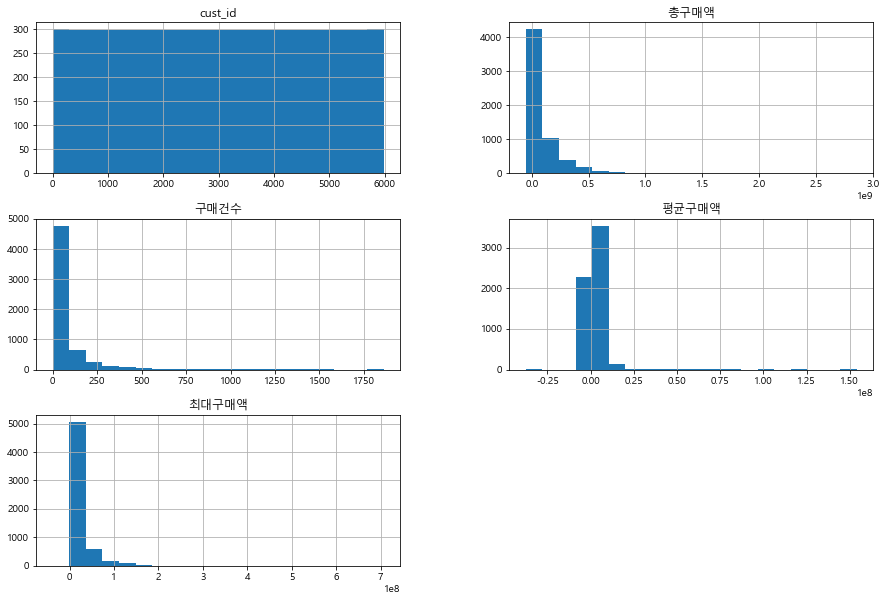

In [6]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [7]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3
0,0,68282840,74,922741,11264000,35,28,17
1,1,2136000,3,712000,2136000,2,2,2
2,2,3197000,4,799250,1639000,1,2,2
3,3,16077620,44,365400,4935000,24,20,13
4,4,29050000,3,9683333,24000000,2,3,3
...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7
5978,5978,480000,1,480000,480000,1,1,1
5979,5979,260003790,71,3662025,25750000,38,28,19
5980,5980,88991520,18,4943973,18120000,9,7,5


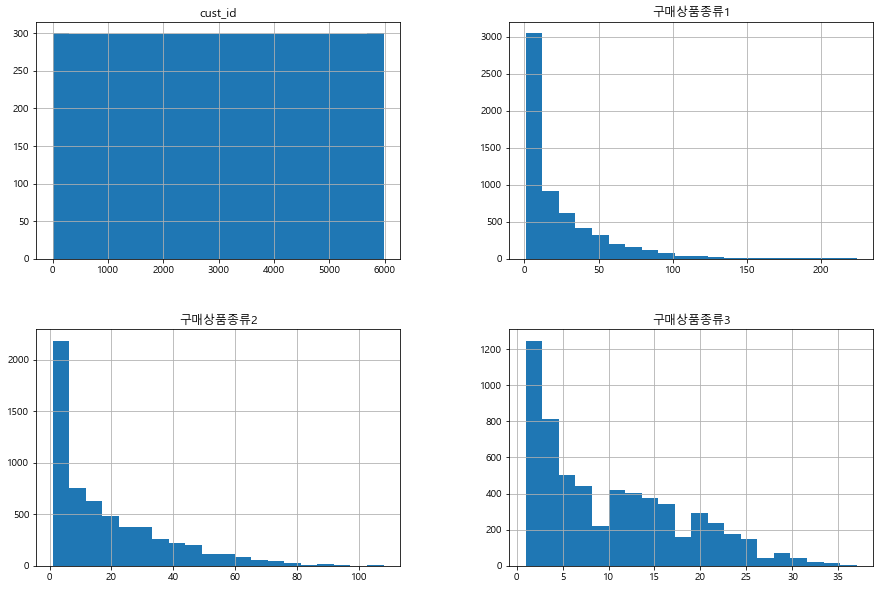

In [8]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [9]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,0.642857,0.071429,0.285714,0.285714,0.357143
5978,5978,480000,1,480000,480000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,0.915493,0.154930,0.225352,0.154930,0.464789
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,0.444444,0.277778,0.166667,0.277778,0.277778


**[파생변수 15-16]** 환불금액, 환불건수

In [10]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,0.642857,0.071429,0.285714,0.285714,0.357143,NaN,NaN
5978,5978,480000,1,480000,480000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,0.915493,0.154930,0.225352,0.154930,0.464789,NaN,NaN
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,0.444444,0.277778,0.166667,0.277778,0.277778,NaN,NaN


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [11]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,0.642857,0.071429,0.285714,0.285714,0.357143,NaN,NaN,1.032269e+07,1.750000
5978,5978,480000,1,480000,480000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,4.800000e+05,1.000000
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,0.915493,0.154930,0.225352,0.154930,0.464789,NaN,NaN,1.368441e+07,3.736842
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,0.444444,0.277778,0.166667,0.277778,0.277778,NaN,NaN,1.779830e+07,3.600000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [12]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
4199,5973,3212500,6
4200,5976,26358000,11
4201,5977,36256000,5
4202,5979,121061000,21


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
4759,5973,5712500,7
4760,5976,136971800,48
4761,5977,44158500,7
4762,5979,159653190,39


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
5977,5977,82581500,14
5978,5978,480000,1
5979,5979,260003790,71
5980,5980,88991520,18


<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [13]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,NaN,1.032269e+07,1.750000,36256000.0,5.0,44158500.0,7.0,82581500,14,골프
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,NaN,4.800000e+05,1.000000,NaN,NaN,NaN,NaN,480000,1,섬유잡화
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,NaN,1.368441e+07,3.736842,121061000.0,21.0,159653190.0,39.0,260003790,71,남성 캐주얼
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,NaN,1.779830e+07,3.600000,7528530.0,2.0,41243840.0,10.0,88991520,18,육류


<AxesSubplot:xlabel='count', ylabel='주구매상품'>

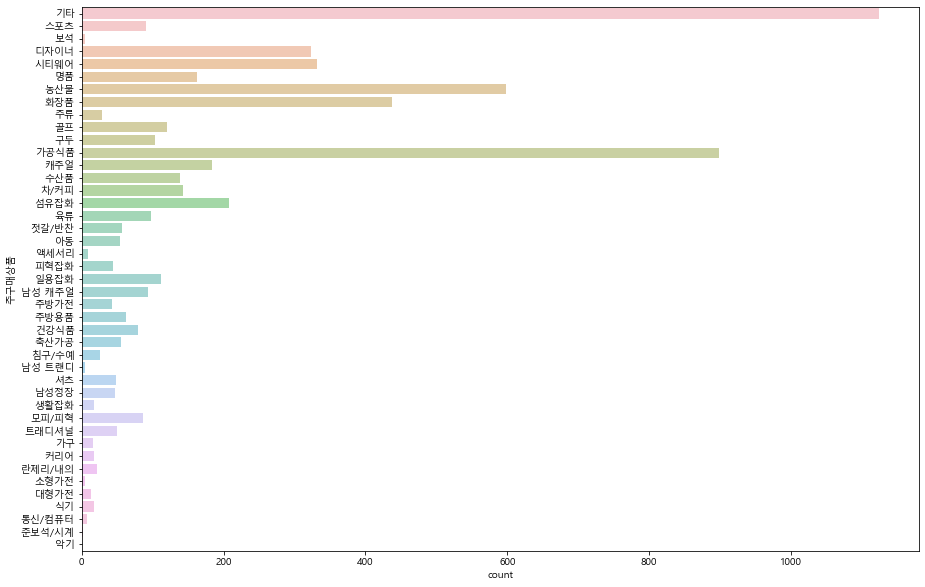

In [14]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 26]** 주구매 지점

In [15]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,1.032269e+07,1.750000,36256000.0,5.0,44158500.0,7.0,82581500,14,골프,부산본점
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,4.800000e+05,1.000000,NaN,NaN,NaN,NaN,480000,1,섬유잡화,광주점
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,1.368441e+07,3.736842,121061000.0,21.0,159653190.0,39.0,260003790,71,남성 캐주얼,본 점
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,1.779830e+07,3.600000,7528530.0,2.0,41243840.0,10.0,88991520,18,육류,본 점


<br><font color='green'>
### Feature Correlation

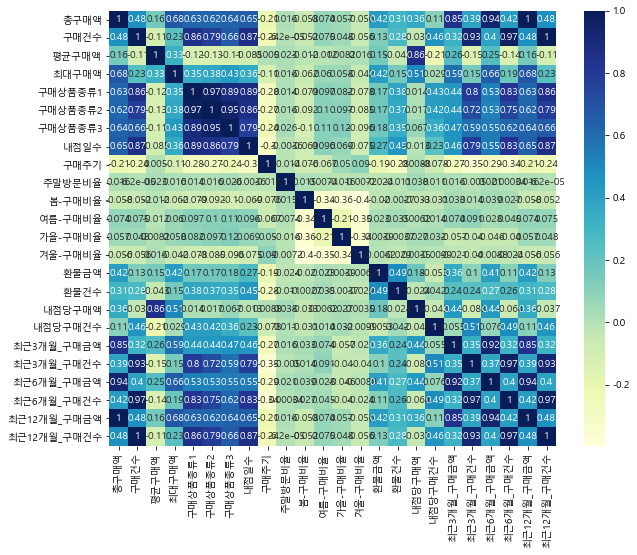

In [16]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

<font color="blue"><p>
## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 학습용과 평가용으로 분리되어 저장된다.

In [17]:
display(features)
features.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,1.032269e+07,1.750000,36256000.0,5.0,44158500.0,7.0,82581500,14,골프,부산본점
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,4.800000e+05,1.000000,NaN,NaN,NaN,NaN,480000,1,섬유잡화,광주점
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,1.368441e+07,3.736842,121061000.0,21.0,159653190.0,39.0,260003790,71,남성 캐주얼,본 점
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,1.779830e+07,3.600000,7528530.0,2.0,41243840.0,10.0,88991520,18,육류,본 점


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cust_id      5982 non-null   int64  
 1   총구매액         5982 non-null   int64  
 2   구매건수         5982 non-null   int64  
 3   평균구매액        5982 non-null   int64  
 4   최대구매액        5982 non-null   int64  
 5   구매상품종류1      5982 non-null   int64  
 6   구매상품종류2      5982 non-null   int64  
 7   구매상품종류3      5982 non-null   int64  
 8   내점일수         5982 non-null   int64  
 9   구매주기         5982 non-null   int64  
 10  주말방문비율       5982 non-null   float64
 11  봄-구매비율       5982 non-null   float64
 12  여름-구매비율      5982 non-null   float64
 13  가을-구매비율      5982 non-null   float64
 14  겨울-구매비율      5982 non-null   float64
 15  환불금액         2076 non-null   float64
 16  환불건수         2076 non-null   float64
 17  내점당구매액       5982 non-null   float64
 18  내점당구매건수      5982 non-null   float64
 19  최근3개월_

In [18]:
X_train = pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}).merge(features)
X_train.to_csv('X_train.csv', index=False, encoding='cp949')

X_test = pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}).merge(features)
X_test.to_csv('X_test.csv', index=False, encoding='cp949')

<font color="#CC3D3D"><p>
# End